# Identify stars in images

The star catalog **hip_main.dat** consists of columns separated by | and with no header. Column 2 is the star identifier, column 6 is the magnitude, column 9 and 10 are RA and DE in degrees.

In [11]:
%matplotlib inline

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
import simulator as sim
import os

In [14]:
star_catalog = sim.StarCatalog('../data/hip_main.dat')

In [15]:
len(star_catalog.star_vectors)

117955

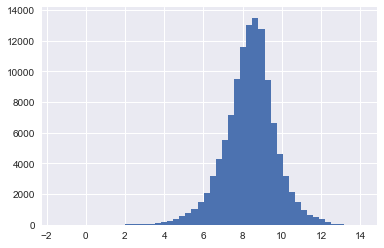

In [16]:
pd.Series(star_catalog.magnitudes).hist(bins=50)

The function *calc_md5* is used to calculate a MD5 checksum from the star catalog to detect changes of the file. In this case the features have to be recalculated.

In [17]:
from hashlib import md5

def calc_md5(file_name):
    fd = open(file_name)
    buffer = fd.read()
    hash = md5(buffer)
    fd.close()
    return hash.hexdigest()

In [18]:
signature = calc_md5('../data/hip_main.dat')

In [19]:
def distance(v):
    return np.sqrt(np.dot(v,v))

def normalized_angle(v1,v2):
    return np.arccos(np.dot(v1,v2)/(distance(v1)*distance(v2)))/np.pi

def distances(v1,v2,v3):
    x3 = distance(v3)
    return (distance(v1) - x3)/(distance(v2) - x3)


In [21]:

# check first if the features have been already calculated
filename = '../data/hip_feat_' + str(signature) + '.csv'
if os.path.exists(filename):
    features = pd.read_csv(filename)
    exit    

# find the two closest stars to each star in the catalog
ids = star_catalog.catalog['HIP'].values
star_catalog.catalog.index = ids
cat = zip(ids, star_catalog.star_vectors,star_catalog.magnitudes)
nearest_stars = []

for hip, pos, mag in cat:

    # get the nearest star
    selection1 = ids != hip
    dist = star_catalog.star_vectors[selection1] - pos
    dist2 = np.sum(dist * dist, axis=1)
    index1 = np.argmin(dist2)
    ids2 = ids[selection1]
    hip1 = ids2[index1]
    pos1 = star_catalog.star_vectors[selection1][index1]
    mag1 = star_catalog.magnitudes[selection1][index1]

    # get the second nearest star
    selection2 = hip1 != ids2
    index2 = np.argmin(dist2[selection2])
    hip2 = ids2[selection2][index2]
    pos2 = star_catalog.star_vectors[selection1][selection2][index2]
    mag2 = star_catalog.magnitudes[selection1][selection2][index2]

    # calculate star measures
    y1 = (mag1 - mag2) / mag
    y2 = normalized_angle(pos1 - pos, pos2 - pos)
    y3 = distances(pos1 - pos, pos2 - pos, pos1 - pos2)
    # print str(hip) + " -> " + str(hip1) + "," + str(hip2) + "," + str(y1) + "," + str(y2) + "," + str(y3)
    nearest_stars.append([hip1, hip2, y1, y2, y3])
    

features = pd.DataFrame(index = ids, 
                        columns = ['hip1',
                                   'hip2',
                                   'nearest_stars_magnitude',
                                   'nearest_stars_angle',
                                   'nearest_stars_distance'], 
                        data = nearest_stars)
features.to_csv(filename)

KeyboardInterrupt: 

In [ ]:
magnitudes = features['nearest_stars_magnitude'].hist(bins = 50)
set(features.index[magnitudes])

In [ ]:
?hist